In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from keras import metrics

from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPool2D, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


# Using CNN Section

## Gamma Function 
Gamma correction, or often simply gamma, is a nonlinear operation used to encode and decode luminance or tristimulus values in video or still image systems.


In [3]:
def adjust_gamma(image, gamma = 1.0):
    invGamma = 1.0 / gamma
    
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [5]:
data = []
gamma = 2.5
normal_count = 0
pneumonia_count = 0
img_size = 50
assign_dict = {"0":0, "1":1}

def get_data(directory):
    for sub_directory in os.listdir(directory):
        if sub_directory == "1":
            inner_directory = os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img = cv2.imread(os.path.join(inner_directory,i),0)
                img =  adjust_gamma(img, gamma=gamma)
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,assign_dict[sub_directory]])
                
        if sub_directory == "0":
            inner_directory = os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img = cv2.imread(os.path.join(inner_directory,i),0)
                img =  adjust_gamma(img, gamma=gamma)
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,assign_dict[sub_directory]])
    random.shuffle(data)  
    return np.array(data)

## Loading Dataset

In [6]:
train = get_data('./Train')
val = get_data('./data')
test = get_data('./Test')

C:\Users\Admin\AppData\Local\Temp\ipykernel_16844\3204518950.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [7]:
image_count = []

directory = './Train'
total_image = 0
'''
  Display  amount of data with driver drowsiness and without_drowsiness
'''

def data_image(directory, total_image):
    for category in os.listdir(directory):
        img_dir = os.path.join(directory, category)
        img = len(os.listdir(img_dir))
        # Tampung gambar
        image_count.append(img)
        total_image += img
        print(f"{category} : {img}")
    print("Total Image : ", total_image)

data_image(directory,total_image)

0 : 13611
1 : 15644
Total Image :  29255


C:\Users\Admin\anaconda3\envs\CPUTensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

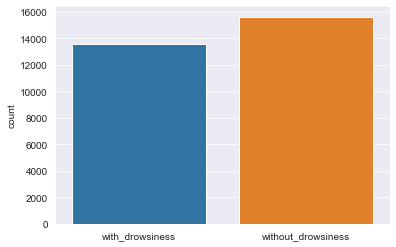

In [8]:
'''
  Display visualization amount of data normal and pneumonia
'''

l = []
for i in train:
    if(i[1] == 0):
        l.append("with_drowsiness")
    else:
        l.append("without_drowsiness")
sns.set_style('darkgrid')
sns.countplot(l)

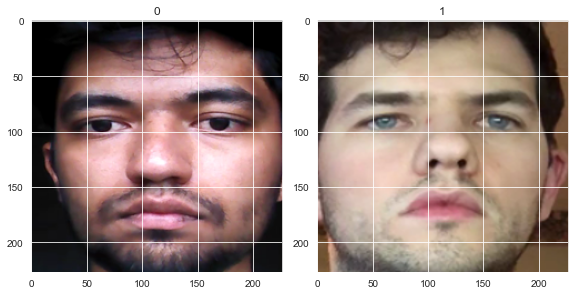

In [9]:
from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

'''
  Display image from sample folder
'''

fig = plt.figure(figsize = (20,15))
ax = []
i = 1

new_dir = './Train'

for image in os.listdir(new_dir):
    ax.append(fig.add_subplot(1,5,i))
    i += 1
    ax[-1].set_title(str(image))
    image_folder = os.path.join(new_dir, image)
    rnd_number = randint(0, len(os.listdir(image_folder)))
    image_file = os.listdir(image_folder)[rnd_number]
    image_file = os.path.join(image_folder, image_file)
    image_show = mpimg.imread(image_file)
    plt.imshow(image_show)

fig.tight_layout()
plt.show()

In [10]:
x_train = []
y_train = []
for features,label in train:
    x_train.append(features)
    y_train.append(label)

In [11]:
x_value = []
y_value = []
for features,label in val:
    x_value.append(features)
    y_value.append(label)

In [12]:
x_test = []
y_test = []
for features,label in test:
    x_test.append(features)
    y_test.append(label)

## Normalize Data

In [13]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_value) / 255
x_test = np.array(x_test) / 255

In [14]:
img_size = 50

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_value)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)



# Data Augmentation
* Data Augmentation simply means increasing the number of Data points. in terms of Images it means the increasing number of images in the Dataset.
* In order to avoid the overfitting problem, we need expand the dataset. This can be acheived by Rotating the Image, Flipping the Image, Zooming the Image, Changing light conditions, Cropping it etc. The more the data, the better our models would perform.

More References :
* https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced

In [15]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [16]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (50,50,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 64)       2

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, 
                              verbose=1,
                              factor=0.3, 
                              min_lr=0.000001)

In [18]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32),
                                 epochs = 12 ,
                                 validation_data = datagen.flow(x_val, y_val),
                                 callbacks = [reduce_lr])

Epoch 1/12
915/915 [==============================] - 191s 206ms/step - loss: 0.2120 - accuracy: 0.9206 - val_loss: 1.3148 - val_accuracy: 0.7398 - lr: 0.0010
Epoch 2/12
915/915 [==============================] - 188s 205ms/step - loss: 0.0453 - accuracy: 0.9881 - val_loss: 2.0472 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 3/12
915/915 [==============================] - 193s 211ms/step - loss: 0.0344 - accuracy: 0.9913 - val_loss: 0.8871 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 4/12
915/915 [==============================] - 186s 204ms/step - loss: 0.0241 - accuracy: 0.9938 - val_loss: 0.4965 - val_accuracy: 0.9029 - lr: 0.0010
Epoch 5/12
915/915 [==============================] - 201s 219ms/step - loss: 0.0199 - accuracy: 0.9951 - val_loss: 2.5784 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 6/12
915/915 [==============================] - 195s 213ms/step - loss: 0.0163 - accuracy: 0.9961 - val_loss: 0.8683 - val_accuracy: 0.9136 - lr: 0.0010
Epoch 7/12
915/915 [==========================

In [19]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1])

2613/2613 [==============================] - 90s 34ms/step - loss: 1.0976 - accuracy: 0.9033
Loss of the model is -  1.0975590944290161
2613/2613 [==============================] - 97s 37ms/step - loss: 1.0976 - accuracy: 0.9033
Accuracy of the model is -  0.9032852649688721


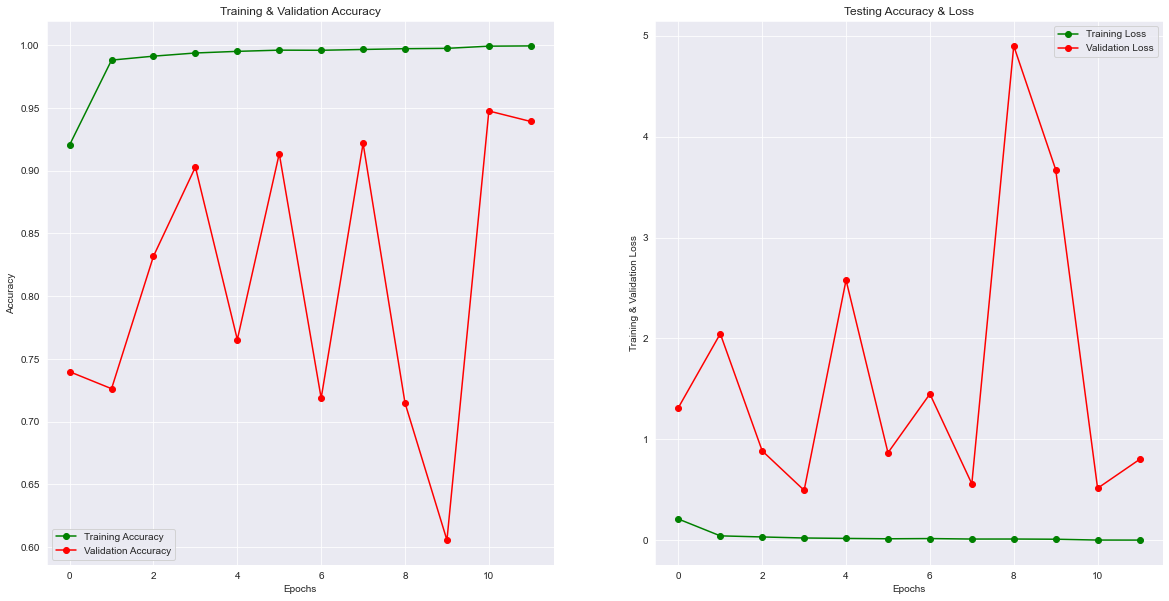

In [20]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [22]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

2613/2613 [==============================] - 67s 26ms/step


array([1.0574622e-03, 1.0000000e+00, 1.4350869e-22, 8.8701454e-06,
       9.9990332e-01, 1.0000000e+00, 1.0000000e+00, 2.2787990e-26,
       1.9413841e-14, 1.8319962e-18, 1.0194159e-15, 1.0000000e+00,
       8.4258078e-20, 7.7723303e-14, 3.7621107e-02], dtype=float32)

In [23]:
print(classification_report(y_test, predictions, target_names = ['Without Mask (Class 0)','With Mask (Class 1)'], digits=4))


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [24]:
cm = confusion_matrix(y_test,predictions)
cm

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [25]:
pred = model.predict(x_test)

2613/2613 [==============================] - 70s 27ms/step


In [23]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['With Mask', 'Without Mask'])
    df_cm2.columns=['With Mask', 'Without Mask']
    f,ax = plt.subplots(figsize=(12, 12))
    #ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()   
    return

In [24]:
#plot_heatmap((np.argmax(y_test,axis =1),predictions),'Face Mask Detection with CNN')

In [25]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

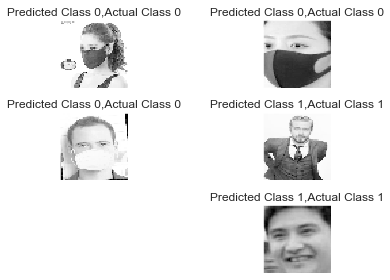

In [26]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(50,50), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [26]:
model.save('cnn2d_weights_2.h5')
model.load_weights('cnn2d_weights_2.h5')

In [27]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

#feat_val = model_feat.predict(x_val)
#print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

915/915 [==============================] - 23s 25ms/step
(29255, 1)
2613/2613 [==============================] - 85s 32ms/step
(83586, 1)


In [28]:
pred = model.predict(x_test)

2613/2613 [==============================] - 87s 33ms/step


In [29]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

2613/2613 [==============================] - 81s 31ms/step


array([1.0574622e-03, 1.0000000e+00, 1.4350869e-22, 8.8701454e-06,
       9.9990332e-01, 1.0000000e+00, 1.0000000e+00, 2.2787990e-26,
       1.9413841e-14, 1.8319962e-18, 1.0194159e-15, 1.0000000e+00,
       8.4258078e-20, 7.7723303e-14, 3.7621107e-02], dtype=float32)

In [30]:
confusion_matrix(y_test,predictions)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [31]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(feat_train,y_train)
print('fitting done !!!')

fitting done !!!


In [32]:
svm.score(feat_train,y_train)
svm.score(feat_test,y_test)
Pred_labels = svm.predict(feat_test)

In [33]:
print(classification_report(Pred_labels,y_test, digits=4))

              precision    recall  f1-score   support

           0     0.8887    0.9024    0.8955     38298
           1     0.9164    0.9044    0.9104     45288

    accuracy                         0.9035     83586
   macro avg     0.9026    0.9034    0.9030     83586
weighted avg     0.9037    0.9035    0.9036     83586



# Applying XGBOOST

In [34]:
import xgboost as xgb
xb = xgb.XGBClassifier()
xb.fit(feat_train,y_train)
print('fitting done !!!')

fitting done !!!


In [35]:
xb.score(feat_train,y_train)
xb.score(feat_test,y_test)
Pred_labels = xb.predict(feat_test)

In [36]:
print(classification_report(Pred_labels,y_test, digits=4))

              precision    recall  f1-score   support

           0     0.8938    0.8981    0.8959     38700
           1     0.9118    0.9079    0.9099     44886

    accuracy                         0.9034     83586
   macro avg     0.9028    0.9030    0.9029     83586
weighted avg     0.9034    0.9034    0.9034     83586



In [37]:
lr = LogisticRegression()
lr.fit(feat_train,y_train)
print('fitting done !!!')

fitting done !!!


In [38]:
Pred_labels = lr.predict(feat_test)
print(classification_report(Pred_labels, y_test, digits=4))

              precision    recall  f1-score   support

           0     0.8918    0.8996    0.8957     38554
           1     0.9134    0.9066    0.9100     45032

    accuracy                         0.9033     83586
   macro avg     0.9026    0.9031    0.9028     83586
weighted avg     0.9034    0.9033    0.9034     83586



In [39]:
dt = DecisionTreeClassifier()
dt.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = dt.predict(feat_test)
print(classification_report(Pred_labels,y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     0.8915    0.8969    0.8942     38654
           1     0.9109    0.9061    0.9085     44932

    accuracy                         0.9018     83586
   macro avg     0.9012    0.9015    0.9013     83586
weighted avg     0.9019    0.9018    0.9019     83586



In [40]:
knn = KNeighborsClassifier()
knn.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = knn.predict(feat_test)
print(classification_report(Pred_labels, y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     0.8918    0.8996    0.8957     38554
           1     0.9134    0.9066    0.9100     45032

    accuracy                         0.9033     83586
   macro avg     0.9026    0.9031    0.9028     83586
weighted avg     0.9034    0.9033    0.9034     83586



In [41]:
lda = LinearDiscriminantAnalysis()
lda.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = lda.predict(feat_test)
print(classification_report(Pred_labels,y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     0.8918    0.8995    0.8956     38558
           1     0.9133    0.9065    0.9099     45028

    accuracy                         0.9033     83586
   macro avg     0.9025    0.9030    0.9028     83586
weighted avg     0.9034    0.9033    0.9033     83586



In [42]:
nb = GaussianNB()
nb.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = nb.predict(feat_test)
print(classification_report(Pred_labels,y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     0.8936    0.8983    0.8959     38686
           1     0.9120    0.9078    0.9099     44900

    accuracy                         0.9034     83586
   macro avg     0.9028    0.9031    0.9029     83586
weighted avg     0.9035    0.9034    0.9034     83586



In [43]:
et = ExtraTreesClassifier()
et.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     0.8916    0.8968    0.8942     38666
           1     0.9107    0.9062    0.9085     44920

    accuracy                         0.9018     83586
   macro avg     0.9012    0.9015    0.9013     83586
weighted avg     0.9019    0.9018    0.9019     83586



In [44]:
estimators = list()
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('LR', LogisticRegression()))
estimators.append(('DTC', DecisionTreeClassifier()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('NB', GaussianNB()))
#estimators.append(('SVM', GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)))
estimators.append(('XGB', XGBClassifier()))

In [45]:
ensemble = VotingClassifier(estimators=estimators, voting='soft')
ensemble.fit(feat_train,y_train)
print('fitting done !!!')
Pred_labels = ensemble.predict(feat_test)
print(classification_report(Pred_labels, y_test, digits=4))

fitting done !!!
              precision    recall  f1-score   support

           0     0.8918    0.8995    0.8956     38558
           1     0.9133    0.9065    0.9099     45028

    accuracy                         0.9033     83586
   macro avg     0.9025    0.9030    0.9028     83586
weighted avg     0.9034    0.9033    0.9033     83586



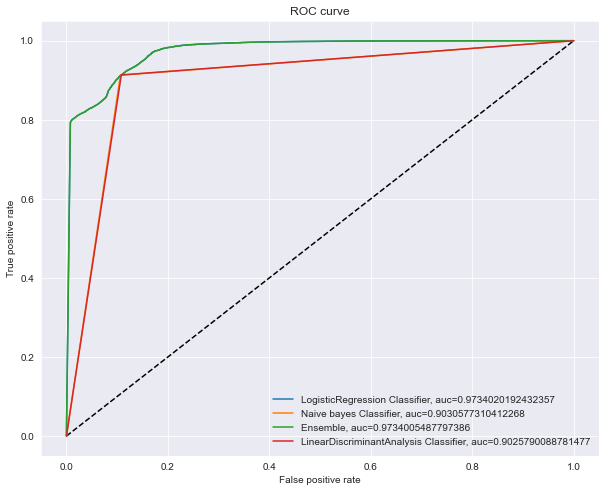

In [46]:
from sklearn import metrics
from sklearn.metrics import roc_curve


clf2=LogisticRegression().fit(feat_train,y_train)
y_pred2 = clf2.predict(feat_test)

clf3 = GaussianNB().fit(feat_train,y_train)
y_pred3 = clf3.predict(feat_test)

clf4 = ensemble.fit(feat_train,y_train)
y_pred4 = clf4.predict(feat_test)

clf6=LinearDiscriminantAnalysis().fit(feat_train,y_train)
y_pred6 = clf6.predict(feat_test)

#clf7=SVC(kernel='rbf').fit(feat_train,np.argmax(y_train,axis=1))
#y_pred7 = clf7.predict(feat_test)

y_pred_proba2 = clf2.predict_proba(feat_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

y_pred_proba3 = clf3.predict_proba(feat_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba3)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba3)

y_pred_proba4 = clf4.predict_proba(feat_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_proba4)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba4)

y_pred_proba6 = clf6.predict_proba(feat_test)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(y_test,  y_pred_proba6)
auc6 = metrics.roc_auc_score(y_test, y_pred_proba6)

#y_pred_proba7 = clf7.predict_proba(feat_test)[::,1]
#fpr7, tpr7, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba7)
#auc7 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba7)


plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2,tpr2,label="LogisticRegression Classifier, auc="+str(auc2))
plt.plot(fpr3,tpr3,label="Naive bayes Classifier, auc="+str(auc3))
plt.plot(fpr4,tpr4,label="Ensemble, auc="+str(auc4))
plt.plot(fpr6,tpr6,label="LinearDiscriminantAnalysis Classifier, auc="+str(auc6))
#plt.plot(fpr7,tpr7,label="SVC Classifier, auc="+str(auc7))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(frameon=False)
plt.show()

# Using VGG16 Section

In [52]:
train_dir = "./Train"
test_dir = "./Test"
val_dir = "./data"

In [53]:
IMG_SIZE = 50#320

In [54]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16

vgg_model = VGG16(input_shape= (IMG_SIZE, IMG_SIZE,3), 
                  weights='imagenet',
                  include_top=False)

for layer in vgg_model.layers:
    layer.trainable = False

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

vgg_output = vgg_model.output

flatten = Flatten()(vgg_output)
Dense_layer1 = Dense(units = 256,activation='relu')(flatten)
Dense_layer2 = Dense(units=128,activation='relu')(Dense_layer1)
Dense_layer3 = Dense(units = 64,activation='relu')(Dense_layer2)
output_layer = Dense(2,activation='sigmoid')(Dense_layer3)

In [56]:
from keras.models import *

model = Model(inputs = vgg_model.input,
              outputs = output_layer)

In [57]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [58]:
import keras

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [59]:
from keras.preprocessing.image import ImageDataGenerator

image_generator_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip = True,
    vertical_flip = False
)


image_generator_test = ImageDataGenerator(
     rescale = 1./255

)

In [60]:
train = image_generator_train.flow_from_directory(train_dir, 
                                            batch_size=32,
                                            class_mode='categorical',
                                            target_size = (IMG_SIZE,IMG_SIZE))

validation = image_generator_test.flow_from_directory(test_dir, 
                                                batch_size=32,
                                                shuffle = True,
                                                class_mode='categorical',
                                                target_size = (IMG_SIZE,IMG_SIZE))

Found 6042 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [61]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

callback_list = ModelCheckpoint('vgg16_model_file.h5', 
                                 monitor='val_accuracy', 
                                 verbose=True, 
                                 save_best_only=True)

In [62]:
r = model.fit(
    train,
    epochs = 15,
    validation_data = validation,
    validation_steps = len(validation),
    steps_per_epoch = 100,
    callbacks = [callback_list]
)

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 0.5921 - accuracy: 0.7116

C:\Users\Eng Kadebu\.conda\envs\images\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 00001: val_accuracy improved from -inf to 0.77417, saving model to vgg16_model_file.h5
100/100 [==============================] - 74s 737ms/step - loss: 0.5921 - accuracy: 0.7116 - val_loss: 0.5037 - val_accuracy: 0.7742
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.8031
Epoch 00002: val_accuracy did not improve from 0.77417
100/100 [==============================] - 44s 441ms/step - loss: 0.4299 - accuracy: 0.8031 - val_loss: 0.4813 - val_accuracy: 0.7391
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.3730 - accuracy: 0.8356
Epoch 00003: val_accuracy did not improve from 0.77417
100/100 [==============================] - 38s 382ms/step - loss: 0.3730 - accuracy: 0.8356 - val_loss: 0.4864 - val_accuracy: 0.7391
Epoch 4/15
100/100 [==============================] - ETA: 0s - loss: 0.3547 - accuracy: 0.8447
Epoch 00004: val_accuracy improved from 0.77417 to 0.78940, saving model to vgg16_model_file.h5
100/100 [=

In [63]:
my_model = keras.models.load_model('./vgg16_model_file.h5')

test_pred = []
test_actual = []
label_dict = {
    0 : "with_mask",
    1 : "without_mask"
}

normal_path = './Test/with_mask'
pneumonia_path = './Test/without_mask'

In [64]:
my_model.evaluate_generator(train,steps = 32,verbose = 1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
32/32 [==============================] - 7s 231ms/step - loss: 0.2561 - accuracy: 0.8906


[0.25610285997390747, 0.890625]

In [65]:
my_model.evaluate_generator(validation,steps = 32, verbose = 1)

32/32 [==============================] - 9s 277ms/step - loss: 0.4446 - accuracy: 0.7871


[0.4446175694465637, 0.787109375]